In [8]:
import torch
import torch.nn.functional as F
from geomloss import SamplesLoss
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Optional
from tqdm import tqdm

In [21]:
# --- 1. Centralisation des Paramètres ---


@dataclass
class OTConfig:
    """Configuration pour Transport Optimal 5D."""

    # Résolution de travail (la grille de calcul)
    # 32x32 ou 48x48 recommandé pour test rapide (O(N^2))
    # 64x64 est faisable sur GPU (< 5 sec avec KeOps)
    resolution: tuple[int] = (48, 48)

    # Échelle de flou entropique (Epsilon).
    blur: float = 0.01

    # Scaling GeomLoss (Précision)
    scaling: float = 0.9

    # Unbalanced parameter (rho). None = Balanced.
    reach: Optional[float] = 0.5

    # Poids de la couleur dans le coût 5D.
    # lambda ~ 0.5 à 2.0.
    # Si très grand -> transporte uniquement les couleurs (ignore l'espace).
    lambda_color: float = 1.0

    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # Paramètres du Splatting Adaptatif
    sigma_start: float = 1.2  # Large pour le Pixel Art (remplit les gros blocs)
    sigma_end: float = 0.5  # Fin pour la Photo (détails nets)
    sigma_boost: float = 0.5  # Boost supplémentaire à t=0.5 pour le tearing

In [11]:
# --- 2. Utilitaires Vectorisés ---


def get_5d_cloud(img: torch.Tensor, res: int, lambda_c: float):
    """
    Convertit une image (C, H, W) en nuage de points 5D (N, 5).
    Dimensions: [x, y, lambda*r, lambda*g, lambda*b]
    Masse: Uniforme (1/N) pour chaque pixel non ignoré.
    """
    C, H, W = img.shape

    # Downsampling
    scale = res / max(H, W)
    new_H, new_W = int(H * scale), int(W * scale)
    if new_H != H or new_W != W:
        img = F.interpolate(
            img.unsqueeze(0), size=(new_H, new_W), mode="bilinear"
        ).squeeze(0)

    # Coordonnées (x, y) normalisées dans [0, 1]
    y = torch.linspace(0, 1, new_H, device=img.device)
    x = torch.linspace(0, 1, new_W, device=img.device)
    yy, xx = torch.meshgrid(y, x, indexing="ij")

    # (N, 2) spatial
    pos_spatial = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

    # (N, 3) couleur
    colors = img.permute(1, 2, 0).reshape(-1, C)

    # Concaténation 5D : [Space, Lambda * Color]
    # On pondère la couleur pour équilibrer le coût
    cloud_5d = torch.cat([pos_spatial, lambda_c * colors], dim=-1)

    # Masses uniformes (pour traiter tout le monde à égalité)
    # Note: On pourrait filtrer les pixels noirs ici si on voulait faire du "Sparse OT"
    N = cloud_5d.shape[0]
    weights = torch.ones(N, device=img.device) / N

    return cloud_5d, weights, colors, new_H, new_W


def vectorized_gaussian_splatting(positions_2d, attributes, weights, H, W, sigma):
    """
    Splatting Vectorisé (Nadaraya-Watson Kernel Regression).

    positions_2d : (N, 2) coordonnées spatiales dans [0, 1]
    attributes   : (N, C) valeurs à splatter (ici RGB)
    weights      : (N,) masse des particules
    sigma        : écart-type du noyau gaussien (en pixels)

    Retourne : (C, H, W) Image reconstruite
    """
    device = positions_2d.device
    N = positions_2d.shape[0]

    # Conversion en coordonnées pixels
    pos_pix = positions_2d * torch.tensor([W - 1, H - 1], device=device)

    # Rayon du noyau (3 sigma couvre 99%)
    radius = int(np.ceil(3 * sigma))
    diameter = 2 * radius + 1

    # --- 1. Définition de la grille locale (Broadcasting) ---
    # Coordonnées entières du centre (N, 2)
    center_pix = torch.round(pos_pix).long()

    # Offsets locaux : grille de taille (diameter, diameter)
    # Création d'une grille locale relative (K*K, 2)
    d_range = torch.arange(-radius, radius + 1, device=device)
    dy, dx = torch.meshgrid(d_range, d_range, indexing="ij")
    offsets = torch.stack([dx, dy], dim=-1).reshape(-1, 2)  # (K*K, 2)

    # Voisins : (N, K*K, 2)
    # neighbor_coords[i, k] = pixel absolu du k-ième voisin de la particule i
    neighbor_coords = center_pix.unsqueeze(1) + offsets.unsqueeze(0)

    # Masque de validité (dans l'image)
    x_neigh = neighbor_coords[:, :, 0]
    y_neigh = neighbor_coords[:, :, 1]
    mask = (x_neigh >= 0) & (x_neigh < W) & (y_neigh >= 0) & (y_neigh < H)

    # --- 2. Calcul des poids Gaussiens ---
    # Position flottante précise projetée sur la grille voisine
    # dist_sq = || pos_pix - neighbor_coords ||^2
    # astuce : pos_pix shape (N, 1, 2), neighbor shape (N, K*K, 2)
    dist_sq = ((pos_pix.unsqueeze(1) - neighbor_coords.float()) ** 2).sum(dim=-1)

    # Gaussian kernel: w_ik
    gauss_weights = torch.exp(-dist_sq / (2 * sigma**2))

    # Application du masque et de la masse de la particule
    # total_weight_ik = pi_i * K(dist) * mask
    contrib_weights = (gauss_weights * weights.unsqueeze(1)) * mask.float()

    # --- 3. Accumulation (Scatter) ---
    # On a besoin d'indices linéaires pour scatter_add
    # flat_indices : (N, K*K) -> indices dans l'image aplatie (H*W)
    flat_indices = y_neigh * W + x_neigh

    # Pour ne pas scatter hors bornes avec les indices masqués, on clamp à 0 (et le poids est 0)
    flat_indices = flat_indices.clamp(0, H * W - 1)

    # A. Accumulateur de poids (Dénominateur)
    denom = torch.zeros(H * W, device=device)
    denom.scatter_add_(0, flat_indices.view(-1), contrib_weights.view(-1))

    # B. Accumulateur de couleurs (Numérateur)
    # attributes : (N, 3) -> (N, 1, 3)
    # weighted_attribs : (N, K*K, 3)
    weighted_attribs = attributes.unsqueeze(1) * contrib_weights.unsqueeze(-1)

    C_channels = attributes.shape[1]
    numer = torch.zeros(H * W, C_channels, device=device)

    # On doit iterer sur les channels ou reshaper, scatter_add gère mal le multidim direct sur index 1D
    for c in range(C_channels):
        val_c = weighted_attribs[:, :, c].view(-1)
        numer[:, c].scatter_add_(0, flat_indices.view(-1), val_c)

    # --- 4. Normalisation ---
    # Éviter division par zéro
    denom = denom.clamp(min=1e-6)

    # Image finale
    out_img = numer / denom.unsqueeze(1)  # (H*W, C)
    out_img = out_img.reshape(H, W, C_channels).permute(2, 0, 1)  # (C, H, W)

    return out_img


def compute_sinkhorn_evolution(frames, img_target, config):
    """
    Calcule la divergence de Sinkhorn S_eps(frame_t, target) pour chaque frame.

    Args:
        frames: Liste des tenseurs (C, H, W) générés par l'interpolation.
        img_target: Tenseur cible (C, H, W).
        config: Ta configuration OTConfig utilisée pour le transport.
    """

    # On réutilise la même configuration de Loss que pour le transport
    # GeomLoss calcule S_eps par défaut (debias=True est le défaut implicite souvent,
    # mais on peut le forcer pour être sûr d'avoir la formule Eq. 14 du papier).
    # Note: Pour une mesure scalaire précise, on utilise potentials=False (par défaut).
    metric_loss = SamplesLoss(
        loss="sinkhorn",
        p=2,
        blur=config.blur,
        reach=config.reach,
        scaling=config.scaling,
        debias=True,  # Active la formule S_eps = OT_ab - 0.5*OT_aa - 0.5*OT_bb
    )

    distances = []

    # 1. Préparation de la cible en Nuage 5D
    # On utilise ta fonction existante get_5d_cloud
    target_cloud, target_weights, _, _, _ = get_5d_cloud(
        img_target.to(config.device), config.resolution[1], config.lambda_color
    )

    print("Calcul des distances de Sinkhorn...")

    for i, frame in enumerate(frames):
        # 2. Conversion de la frame générée (image) en Nuage 5D
        # C'est crucial : on compare dans l'espace 5D (Geometry + Color)
        current_cloud, current_weights, _, _, _ = get_5d_cloud(
            frame.to(config.device),
            config.resolution[0],  # Ou la résolution de la frame si différente
            config.lambda_color,
        )

        # 3. Calcul de la perte S_eps(mu_t, nu)
        # SamplesLoss attend (weights, positions)
        loss_val = metric_loss(
            current_weights, current_cloud, target_weights, target_cloud
        )

        distances.append(loss_val.item())
        print(f"Frame {i}: Sinkhorn Div = {loss_val.item():.4f}")

    return distances

In [45]:
# --- 3. Moteur de Transport 5D ---


class OT5DInterpolator:
    def __init__(self, config: OTConfig):
        self.cfg = config
        self.loss_layer = SamplesLoss(
            loss="sinkhorn", p=2, blur=config.blur, reach=config.reach,
            debias=False, potentials=True, scaling=config.scaling, backend="auto"
        )

    def interpolate(self, img_source, img_target, times: List[float]):
        # 1. Préparation 5D (inchangé)
        X_a, w_a, colors_a, Ha, Wa = get_5d_cloud(
            img_source.to(self.cfg.device),
            self.cfg.resolution[0],
            self.cfg.lambda_color,
        )
        X_b, w_b, colors_b, Hb, Wb = get_5d_cloud(
            img_target.to(self.cfg.device),
            self.cfg.resolution[1],
            self.cfg.lambda_color,
        )

        # 2. Sinkhorn & Plan pi (inchangé)
        F_pot, G_pot = self.loss_layer(w_a, X_a, w_b, X_b)
        F_pot, G_pot = F_pot.flatten(), G_pot.flatten()

        dist_sq = torch.cdist(X_a, X_b, p=2) ** 2
        C_matrix = dist_sq / 2.0
        epsilon = self.cfg.blur**2

        # Reconstruction log-domain stable
        log_pi = (
            (F_pot[:, None] + G_pot[None, :] - C_matrix) / epsilon
            + torch.log(w_a.flatten()[:, None])
            + torch.log(w_b.flatten()[None, :])
        )
        pi = torch.exp(log_pi).squeeze()

        # Filtrage Sparse (inchangé)
        mask = pi > (pi.max() * 1e-4)
        I_idx, J_idx = mask.nonzero(as_tuple=True)
        weights_ij = pi[I_idx, J_idx]

        # Pré-chargement des données
        pos_a_spatial = X_a[I_idx, :2]
        pos_b_spatial = X_b[J_idx, :2]
        col_a_real = colors_a[I_idx]
        col_b_real = colors_b[J_idx]

        results = []

        # Calcul de la densité théorique pour éviter les trous
        # Densité = (H*W) / N_points. Si sigma < sqrt(Densité), on a des trous.
        # On calcule un "Safety Sigma" minimal.
        N_active = weights_ij.shape[0]
        # Estimation grossière de l'espacement moyen entre particules
        avg_spacing = np.sqrt((Hb * Wb) / (N_active + 1e-6))
        min_sigma_theoretical = avg_spacing / 2.0  # Critère de Nyquist

        for t in tqdm(times, desc="Interpolation 5D"):
            # A. Barycentre Géodésique
            pos_t = (1 - t) * pos_a_spatial + t * pos_b_spatial
            col_t = (1 - t) * col_a_real + t * col_b_real

            # B. Sigma "Intelligent"
            sigma_intrinsic = (1 - t) * self.cfg.sigma_start + t * self.cfg.sigma_end
            sigma_expansion = self.cfg.sigma_boost * 4 * t * (1 - t)

            # Calcul dynamique de la taille de la grille (Canvas)
            # On interpole linéairement les dimensions
            Ht = int((1 - t) * Ha + t * Hb)
            Wt = int((1 - t) * Wa + t * Wb)

            # Mise à jour du sigma min théorique pour la grille actuelle
            # Densité courante approx = (Ht*Wt) / N_active
            current_spacing = np.sqrt((Ht * Wt) / (N_active + 1e-6))
            min_sigma_t = current_spacing / 2.0

            # Sigma final
            sigma_t = max(sigma_intrinsic + sigma_expansion, min_sigma_t * 0.8)

            # C. Splatting sur la grille dynamique (Ht, Wt)
            img_t = vectorized_gaussian_splatting(
                pos_t, col_t, weights_ij, Ht, Wt, sigma=sigma_t
            )

            results.append(img_t.cpu())

        return results

--- 5D OT Transport (Joint Spatial-Color) ---
Res: (32, 64), Lambda: 2.0, Reach: 0.3


Interpolation 5D: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


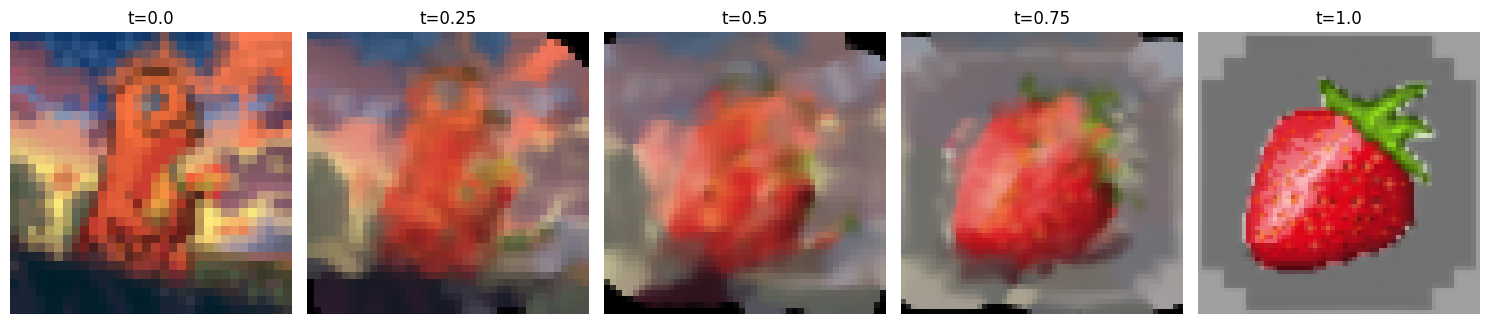

In [49]:
# --- 4. Main ---


def main():
    # Setup
    config = OTConfig(
        resolution=(32, 64),  # Compromis vitesse/qualité pour le rendu interactif
        blur=0.05,
        reach=0.3,  # Autorise la création/destruction de masse
        lambda_color=2.0,  # Force à matcher les couleurs similaires
        sigma_start= 0.5,
        sigma_end= 0.5,
        sigma_boost= 0.4,
    )

    print(f"--- 5D OT Transport (Joint Spatial-Color) ---")
    print(
        f"Res: {config.resolution}, Lambda: {config.lambda_color}, Reach: {config.reach}"
    )

    # Chargement Images (Dummy ou Fichier)
    try:
        # Remplacer par vos chemins
        img1_pil = Image.open("../data/pixelart/images/salameche.webp").convert("RGB")
        img2_pil = Image.open("../data/pixelart/images/fraise.webp").convert("RGB")
    except:
        print("Images non trouvées, génération synthétique (Rouge -> Bleu)...")
        img1_pil = Image.fromarray(np.zeros((64, 64, 3), dtype=np.uint8))
        img2_pil = Image.fromarray(np.zeros((64, 64, 3), dtype=np.uint8))
        # Carré Rouge
        img1_pil.paste((255, 0, 0), (10, 10, 30, 30))
        # Carré Bleu décalé
        img2_pil.paste((0, 0, 255), (34, 34, 54, 54))

    img1 = torch.from_numpy(np.array(img1_pil)).permute(2, 0, 1).float() / 255.0
    img2 = torch.from_numpy(np.array(img2_pil)).permute(2, 0, 1).float() / 255.0

    # Interpolation
    interpolator = OT5DInterpolator(config)
    times = [0.0, 0.25, 0.5, 0.75, 1.0]
    frames = interpolator.interpolate(img1, img2, times)

    # Affichage
    fig, axes = plt.subplots(1, len(times), figsize=(15, 4))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i].permute(1, 2, 0).clamp(0, 1).numpy())
        ax.set_title(f"t={times[i]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    return frames, img2, config, times


if __name__ == "__main__":
    frames, img2, config, times = main()

Calcul des distances de Sinkhorn...
Frame 0: Sinkhorn Div = 0.0795
Frame 1: Sinkhorn Div = 0.0615
Frame 2: Sinkhorn Div = 0.0434
Frame 3: Sinkhorn Div = 0.0252
Frame 4: Sinkhorn Div = 0.0102


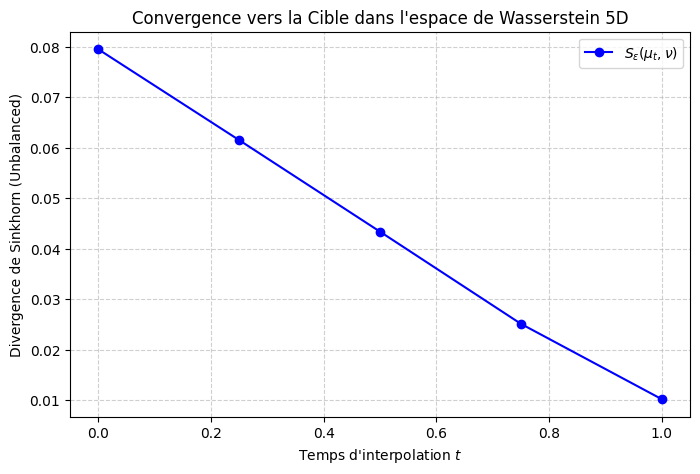

In [50]:
sinkhorn_dists = compute_sinkhorn_evolution(frames, img2, config)

# Visualisation de la courbe
plt.figure(figsize=(8, 5))
plt.plot(
    times,
    sinkhorn_dists,
    marker="o",
    linestyle="-",
    color="b",
    label=r"$S_{\varepsilon}(\mu_t, \nu)$",
)
plt.xlabel("Temps d'interpolation $t$")
plt.ylabel("Divergence de Sinkhorn (Unbalanced)")
plt.title("Convergence vers la Cible dans l'espace de Wasserstein 5D")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()